# Summer temperature anomaly aggregat by country, region, etc


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

from tqdm import tqdm

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC


In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [34]:
MAX_YEAR = 2021
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/summer temperature change/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2022'

GPW_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
# COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

## Load the population data

In [4]:
gpw_ds = xr.open_dataset(GPW_FILE)

In [5]:
population = gpw_ds[POPULATION_VAR]

In [6]:
population = (
    xr.concat([population, 
               population.interp(year=2021, kwargs=dict(fill_value="extrapolate")).compute()
              ], 'year').load())

## Load country data

In [7]:
COUNTRIES_RASTER = gpw_ds['National Identifier Grid, v4.11 (2010): National Identifier Grid'].load()

In [8]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [9]:
COUNTRIES_LOOKUP.head()

GRIDCODE ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0         4     AFG         4     Afghanistan           4   
1         8     ALB         8         Albania           8   
2        12     DZA        12         Algeria          12   
3        16     ASM        16  American Samoa          16   
4        20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  GRSTART  \
0  Population estimate/projection         6      2011          2     1998   
1                    Final census         1      2011          3     2001   
2                    Final census         1      2008          2     1998   
3                    Final census         1      2010          3     2000   
4             Population register         5      2010          1     2000   

   GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0   2011        1        1979   4507.466751  
1   2011        3        2011    115.949835  
2   2008        2        2008  50884.794880  
3   2010        3        2010      7.612468  
4   2010        1        2011     79.902822

## Load Lancet standardisation data

In [10]:
SD_FOLDER = Path('../../Standardisation guidelines - LIVE FOR AUTHORS')

In [11]:
country_classification = pd.read_excel(SD_FOLDER / 'Country names - ISO3 codes - WHO and HDI classifications2021.xlsx', skiprows=1)

In [12]:
country_classification

Preferred Country Name ISO ALPHA-3 code       WHO Region  \
0                    Aruba              ABW              NaN   
1                   Angola              AGO          African   
2                  Burundi              BDI          African   
3                    Benin              BEN          African   
4             Burkina Faso              BFA          African   
..                     ...              ...              ...   
193                  Tonga              TON  Western Pacific   
194                 Tuvalu              TUV  Western Pacific   
195                Vietnam              VNM  Western Pacific   
196                Vanuatu              VUT  Western Pacific   
197                  Samoa              WSM  Western Pacific   

    Level of human development  Human Development Index in 2018 (HDI)  \
0                          NaN                                    NaN   
1                       Medium                               0.574488   
2                          Low                               0.422882   
3                          Low                               0.519834   
4                          Low                               0.433547   
..                         ...                                    ...   
193                       High                               0.717430   
194                        NaN                                    NaN   
195                     Medium                               0.692669   
196                     Medium                               0.596848   
197                       High                               0.706771   

     HDI rank  
0         NaN  
1       149.0  
2       185.0  
3       163.0  
4       182.0  
..        ...  
193     105.0  
194       NaN  
195     118.0  
196     141.0  
197     111.0  

[198 rows x 6 columns]

In [13]:
world_map_data = gpd.read_file(SD_FOLDER/ 'Shapefiles' / 'detailed_2013.shp').set_index('ISO_3_CODE')

### Load the temperature anomaly data

In [35]:
# Load the anomaly raster
summer_anom = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'summer_temperature_anomaly.nc')

In [36]:
global_timeseries = pd.read_excel(RESULTS_FOLDER / 'summer_temperature_anomaly.xlsx', sheet_name='temperature_change').set_index('year')


In [37]:
global_timeseries.head()

Global mean change K  Exposure weighted change K
year                                                  
1979             -0.095747                         NaN
1980             -0.052429                         NaN
1981             -0.103127                         NaN
1982             -0.134416                         NaN
1983             -0.019737                         NaN

## Load region raster references

In [17]:
who_regions = xr.open_dataarray(POP_DATA_SRC / 'who_regions_15min_era_compat.nc')

In [18]:
hdi_regions = xr.open_dataarray(POP_DATA_SRC / 'hdi_regions_15min_era_compat.nc')

## Exposure weighted change by country

In [46]:
weighted_results = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER == grid_code
    country_population = (country_mask * population).sum(dim=['latitude', 'longitude'])
    country_exposures_ts = (summer_anom * population * country_mask / country_population).sum(dim=['latitude', 'longitude'])

    weighted_results.append(country_exposures_ts.to_dataframe(row.ISOCODE))

weighted_results = pd.concat(weighted_results, axis=1)

100%|██████████| 248/248 [01:35<00:00,  2.60it/s]


In [47]:
weighted_results.to_csv(INTERMEDIATE_RESULTS_FOLDER / 'summer_warming_weighted_change_by_country.csv')

In [51]:
results_by_country.to_csv(RESULTS_FOLDER / 'summer_warming_weighted_change_by_country_long.csv', index=False)

<AxesSubplot:xlabel='year'>

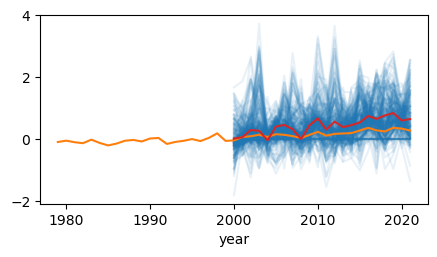

In [50]:
weighted_results.plot(style='C0', legend=False, alpha=0.1)
global_timeseries['Global mean change K'].plot(style='C1', legend=False)
global_timeseries['Exposure weighted change K'].plot(style='C3', legend=False)

In [64]:
plot_data = world_map_data.join(weighted_results.loc[2020])

<AxesSubplot:>

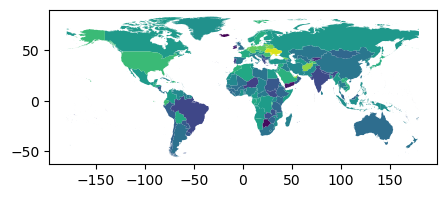

In [65]:
# TODO ekert3 projection
plot_data.plot(column=2020)

## Exposure weighted by WHO region

In [43]:
weighted_results = []
    
for i, region_name in tqdm(enumerate(who_regions.who_region), total=len(who_regions.who_region)):
    mask = who_regions == i
    region_population = (mask * population).sum(dim=['latitude', 'longitude'])
    region_exposures_ts = (summer_anom * population * mask / region_population).sum(dim=['latitude', 'longitude'])

    weighted_results.append(region_exposures_ts.to_dataframe(region_name))

weighted_results = pd.concat(weighted_results, axis=1)

100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


In [44]:
results_by_who_region = (weighted_results.stack()
                         .to_frame('Exposure weighted change K')
                         .reset_index()
                         .rename(columns={'level_1':'WHO Region'})
                         .sort_values(['WHO Region', 'year'])[['WHO Region', 'year', 'Exposure weighted change K']])

In [45]:
results_by_who_region.to_csv(RESULTS_FOLDER / 'summer_warming_weighted_change_by_who_region.csv', index=False)

## Exposure weighted by Human Development Index class


In [38]:
weighted_results = []
    
for i, region_name in tqdm(enumerate(hdi_regions.level_of_human_development), total=len(hdi_regions.level_of_human_development)):
    mask = hdi_regions == i
    region_population = (mask * population).sum(dim=['latitude', 'longitude'])
    region_exposures_ts = (summer_anom * population * mask / region_population).sum(dim=['latitude', 'longitude'])

    weighted_results.append(region_exposures_ts.to_dataframe(region_name))

weighted_results = pd.concat(weighted_results, axis=1)

100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


In [39]:
summer_anom

<xarray.DataArray 't2m' (year: 43, latitude: 721, longitude: 1440)>
[44644320 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021

In [40]:
results_by_hdi_region = (weighted_results.stack()
                         .to_frame('Exposure weighted change K')
                         .reset_index()
                         .rename(columns={'level_1':'HDI Region'})
                         .sort_values(['HDI Region', 'year'])[['HDI Region', 'year', 'Exposure weighted change K']])

In [41]:
results_by_hdi_region.to_csv(RESULTS_FOLDER / 'summer_warming_weighted_change_by_hdi_region.csv', index=False)